# Training

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm

import matplotlib.pyplot as plt

In [2]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.decoder import Decoder
from src.starcattovae.nn.encoder import Encoder
from src.starcattovae.nn.model import Model

from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid

In [3]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

### Define Parameters

In [4]:
# configure parameters
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 320

x_dim = 256
hidden_dim = 512
latent_dim = 32
lr = 1e-3

Using device: mps


## Load Training Data

In [5]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

# Create train and test datasets
train_dataset = Data(indices=train_indices, train=True)
test_dataset = Data(indices=test_indices, train=False)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
test_indices_set = set(test_dataset.get_indices())

overlap = train_indices_set.intersection(test_indices_set)
if len(overlap) == 0:
    print("Train and test sets are different.")
else:
    print("Train and test sets have overlap.")

Train and test sets are different.


In [6]:
train_dataset.summary()
test_dataset.summary()

2024-11-13 22:52:06.714 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)

2024-11-13 22:52:06.715 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)



In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Load Autoencoders

In [8]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder, DEVICE=DEVICE).to(DEVICE)

### Loss Function

In [9]:
# im unsure about the reconstruction loss
def loss_function(x, x_hat, mean, log_var):
    # trying multiple losses
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    reproduction_loss *= 1 * 256
    # reproduction_loss = nn.functional.l1_loss(x_hat, x, reduction='sum')
    # reproduction_loss = nn.functional.binary_cross_entropy_with_logits(x_hat, x, pos_weight=torch.tensor([1.0]).to(DEVICE), reduction='none')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

### Train VAE

Start training VAE...
Epoch 1 complete! 	Average Loss: 209.7054
Epoch 2 complete! 	Average Loss: 111.8873
Epoch 3 complete! 	Average Loss: 88.5773
Epoch 4 complete! 	Average Loss: 75.1519
Epoch 5 complete! 	Average Loss: 68.7887
Epoch 6 complete! 	Average Loss: 64.5810
Epoch 7 complete! 	Average Loss: 60.2856
Epoch 8 complete! 	Average Loss: 57.2032
Epoch 9 complete! 	Average Loss: 54.4232
Epoch 10 complete! 	Average Loss: 52.2682
Epoch 11 complete! 	Average Loss: 49.8422
Epoch 12 complete! 	Average Loss: 48.9238
Epoch 13 complete! 	Average Loss: 48.0355
Epoch 14 complete! 	Average Loss: 46.7792
Epoch 15 complete! 	Average Loss: 46.1089
Epoch 16 complete! 	Average Loss: 45.5345
Epoch 17 complete! 	Average Loss: 44.9094
Epoch 18 complete! 	Average Loss: 43.4347
Epoch 19 complete! 	Average Loss: 43.0799
Epoch 20 complete! 	Average Loss: 42.4018


KeyboardInterrupt: 

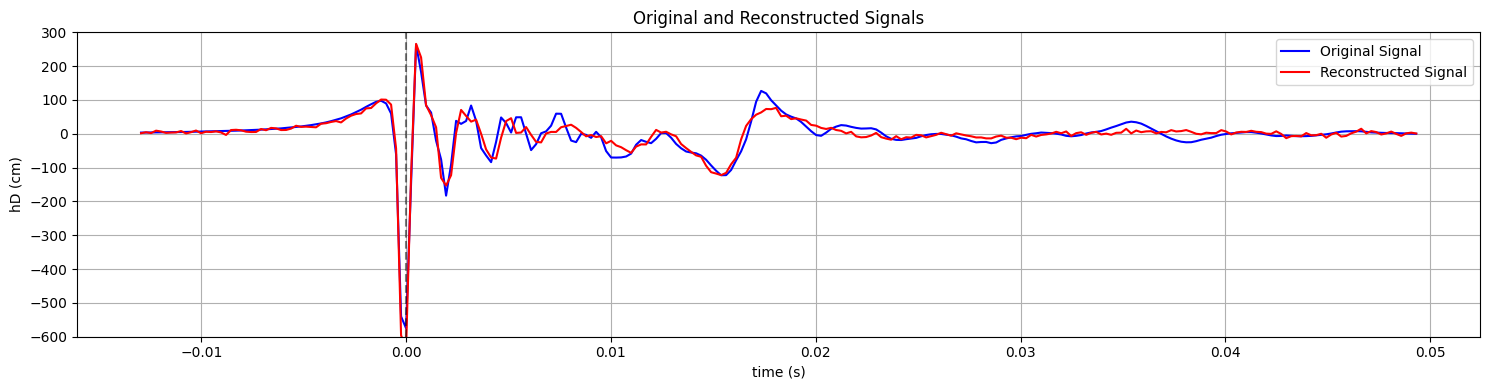

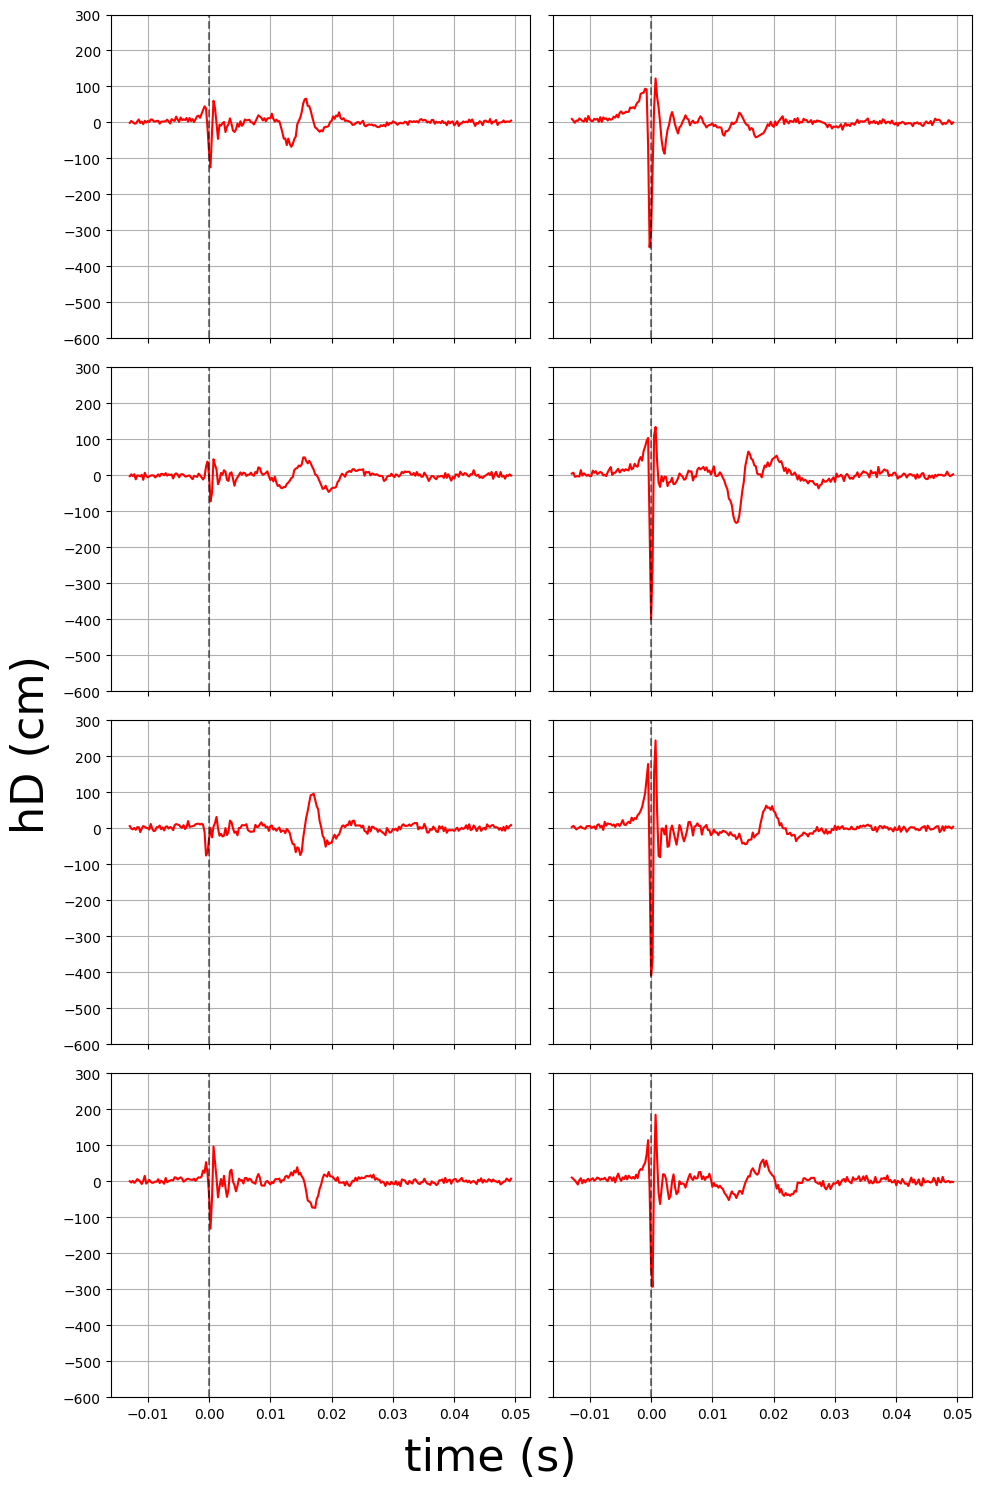

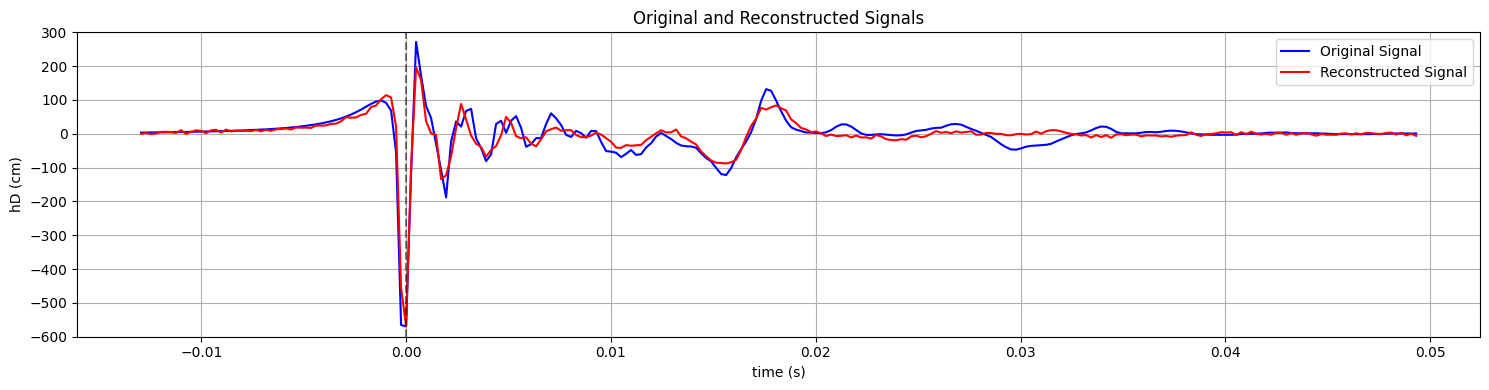

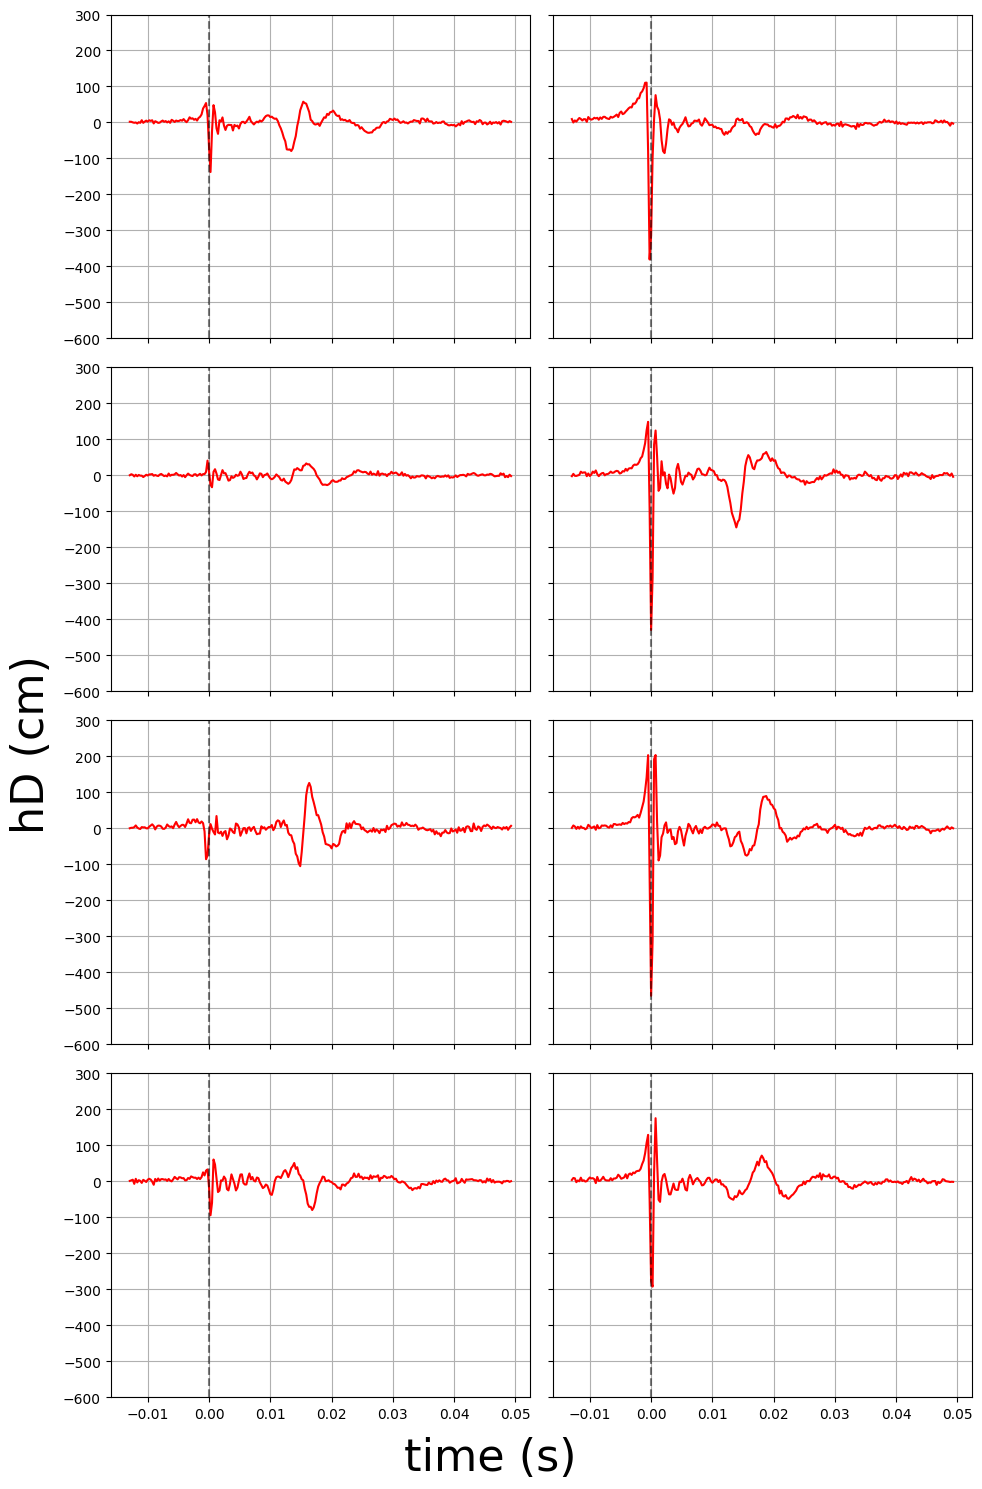

In [10]:
print("Start training VAE...")
model.train()

avg_losses = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)

for epoch in range(epochs):
    overall_loss = 0
    total_samples = 0

    for batch_idx, x in enumerate(train_dataloader, 0):
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        total_samples += x.size(0)

        loss.backward()
        optimizer.step()

    avg_loss = overall_loss / total_samples
    avg_losses.append(avg_loss)
    print(f"Epoch {epoch + 1} complete! \tAverage Loss: {avg_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = decoder(noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

plot_loss(avg_losses)
print("Training finished!")